In [1]:
import jax
import jax.numpy as jnp
import jax.random as random
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

from abmax.structs import * 


import seaborn as sns
sns.set_theme(style="darkgrid")
palette = "viridis"
sns.set_palette(palette)

MAX_SPAWN_X = 100
MAX_SPAWN_Y = MAX_SPAWN_X
PATCH_RADIUS = 5.0
FORAGER_RADIUS = 5.0
EP_LEN = 2000
NUM_FORAGERS = 10
NUM_PATCH = 10

In [2]:
from matplotlib.collections import LineCollection
import numpy as np

def render_static_trajectory(render_data, fig_name):#, filename='forager_trajectory_static.png'):
    # Extract data
    forager_xs = render_data.content['forager_xs']  # shape: (EP_LEN, NUM_FORAGERS)
    forager_ys = render_data.content['forager_ys']  # shape: (EP_LEN, NUM_FORAGERS)
    forager_angs = render_data.content['forager_angs']  # shape: (EP_LEN, NUM_FORAGERS)
    patch_xs = render_data.content['patch_xs']  # shape: (NUM_PATCH, )
    patch_ys = render_data.content['patch_ys']  # shape: (NUM_PATCH, )
    
    # Setup figure
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_xlim(-1.2*MAX_SPAWN_X, 1.2*MAX_SPAWN_X)
    ax.set_ylim(-1.2*MAX_SPAWN_Y, 1.2*MAX_SPAWN_Y)
    ax.set_aspect('equal')
    ax.set_xticks(jnp.arange(-0.6*MAX_SPAWN_X, 1.2*MAX_SPAWN_X+1, 60))
    ax.set_yticks(jnp.arange(-1.2*MAX_SPAWN_Y, 1.2*MAX_SPAWN_Y+1, 60))
    ax.tick_params(axis='both', which='major', labelsize=22)

    
    # Plot patches
    patch_scatter = ax.scatter(patch_xs, patch_ys, c='g', s=PATCH_RADIUS*100, 
                              alpha=0.5, edgecolors='black', linewidths=1.5, label='Patches')
    
    # Plot trajectories for each forager with gradient coloring
    for i in range(NUM_FORAGERS):
        # Extract trajectory for this forager
        x_traj = np.array(forager_xs[:, i])
        y_traj = np.array(forager_ys[:, i])
        
        # Create segments for the line collection
        points = np.array([x_traj, y_traj]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        
        # Create gradient coloring (light at start, dark at end)
        cmap = plt.cm.Blues
        norm = plt.Normalize(0, len(segments))
        lc = LineCollection(segments, cmap=cmap, norm=norm, alpha=0.7, linewidth=1.0)
        
        # Set gradient from dark to light (don't invert the array)
        lc.set_array(np.arange(len(segments)))
        
        # Add line collection to plot
        ax.add_collection(lc)
        
        # Add 'X' marker at starting point
        ax.plot(x_traj[0], y_traj[0], 'X', color='blue', markersize=8, label='Start' if i == 0 else "")
    
    # Final positions with orientation arrows
    final_xs = forager_xs[-1, :]
    final_ys = forager_ys[-1, :]
    final_angs = forager_angs[-1, :]
    
    #make foragers opaque by changing alpha to 1.0
    forager_scatter = ax.scatter(final_xs, final_ys, c='b', s=FORAGER_RADIUS*100, 
                                alpha=0.8, edgecolors='black', linewidths=1.5, label='Foragers')
    forager_quiver = ax.quiver(final_xs, final_ys, 
                              jnp.cos(final_angs), jnp.sin(final_angs), 
                              color='b', scale=20.0)
    #add a dummy line for the trajectory legend
    ax.plot([], [], color='tab:blue', alpha=0.9, lw=1.2, label='Trajectory')

    plt.legend(loc='lower left', fontsize=22)
    plt.savefig(fig_name, bbox_inches='tight')
    
    plt.show()

In [3]:
def analyze_patch_visits(forager_xs, forager_ys, patch_xs, patch_ys, patch_radius=PATCH_RADIUS):
    """
    Analyzes how many different patches each forager visits during their trajectory.
    
    Args:
        forager_xs: Array of shape (EP_LEN, NUM_FORAGERS) with x positions
        forager_ys: Array of shape (EP_LEN, NUM_FORAGERS) with y positions
        patch_xs: Array of shape (NUM_PATCH,) with patch x positions
        patch_ys: Array of shape (NUM_PATCH,) with patch y positions
        patch_radius: Distance threshold to consider a patch "visited"
        
    Returns:
        Dictionary with data for plotting: 
        - 'forager_ids': IDs of each forager
        - 'patch_counts': Number of unique patches visited by each forager
        - 'visits_matrix': Boolean matrix showing which patches each forager visited
    """
    # Convert JAX arrays to numpy for easier manipulation
    forager_xs_np = np.array(forager_xs)
    forager_ys_np = np.array(forager_ys)
    patch_xs_np = np.array(patch_xs)
    patch_ys_np = np.array(patch_ys)
    
    num_foragers = forager_xs_np.shape[1]
    num_patches = len(patch_xs_np)
    
    # Initialize visits matrix
    visits = np.zeros((num_foragers, num_patches), dtype=bool)
    
    # For each forager and patch, check if the forager ever visits the patch
    for f in range(num_foragers):
        for p in range(num_patches):
            # Calculate distances at all timesteps
            distances = np.sqrt((forager_xs_np[:, f] - patch_xs_np[p])**2 + 
                               (forager_ys_np[:, f] - patch_ys_np[p])**2)
            
            # Check if the forager ever comes within patch_radius
            if np.any(distances <= patch_radius):
                visits[f, p] = True
    
    # Count number of patches each forager visits
    patch_counts = np.sum(visits, axis=1)
    
    # Prepare data for plotting
    plot_data = {
        'forager_ids': np.arange(num_foragers),
        'patch_counts': patch_counts,
        'visits_matrix': visits
    }
    
    return plot_data


def plot_patch_visits(render_data, figname):
    # Extract trajectory and patch data
    forager_xs = render_data.content['forager_xs']
    forager_ys = render_data.content['forager_ys']
    patch_xs = render_data.content['patch_xs']
    patch_ys = render_data.content['patch_ys']
    
    # Analyze patch visits
    visit_data = analyze_patch_visits(forager_xs, forager_ys, patch_xs, patch_ys)
    
    # Create bar plot
    fig, ax = plt.subplots(figsize=(10, 6))
    bars = ax.bar(visit_data['forager_ids'], visit_data['patch_counts'])
    
    # Add labels and styling
    ax.set_xlabel('Forager ID', fontsize=16)
    ax.set_ylabel('Number of unique patches visited', fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=12)
    #ax.set_title('Patch Visitation by Foragers', fontsize=16)
    ax.set_xticks(visit_data['forager_ids'], fontsize=15)
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Add value labels on top of each bar
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                f'{height:.0f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.savefig(figname, bbox_inches='tight')
    plt.show()
    
    return visit_data

(43, 2000, 10, 1) (43, 2000, 10, 1) (43, 2000, 10, 1) (43, 10) (43, 10) (43, 2000, 10, 1)
(43, 2000, 10) (43, 2000, 10) (43, 2000, 10) (43, 10) (43, 10) (43, 2000, 10)


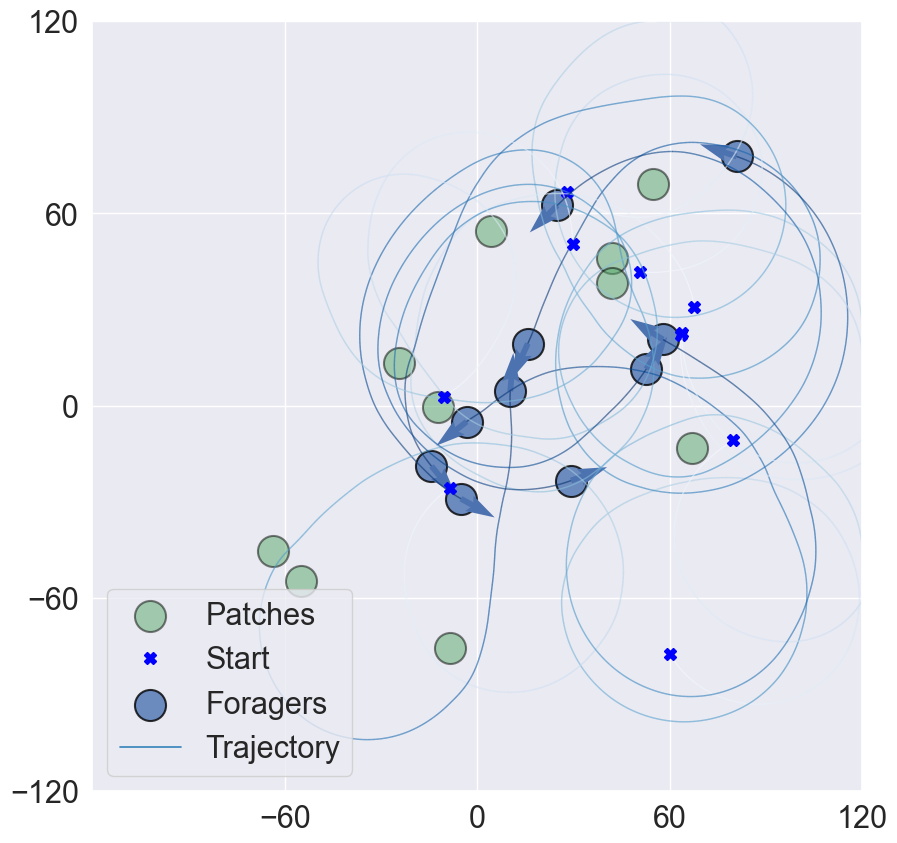

(43, 2000, 10) (43, 2000, 10) (43, 2000, 10) (43, 10) (43, 10) (43, 2000, 10)


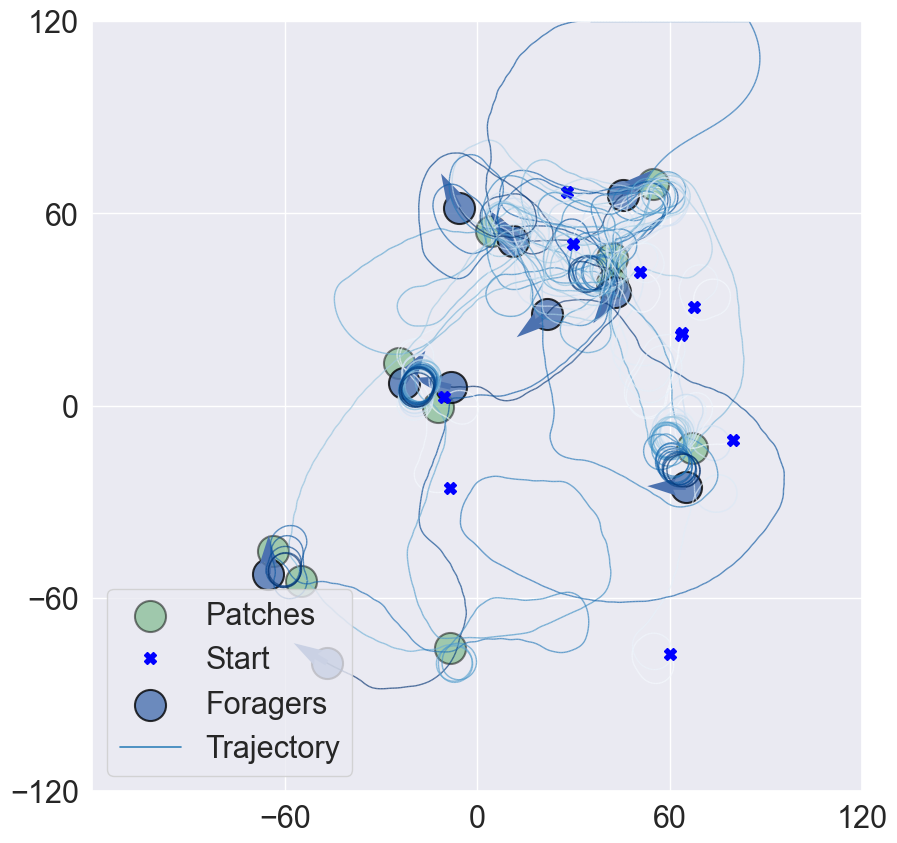

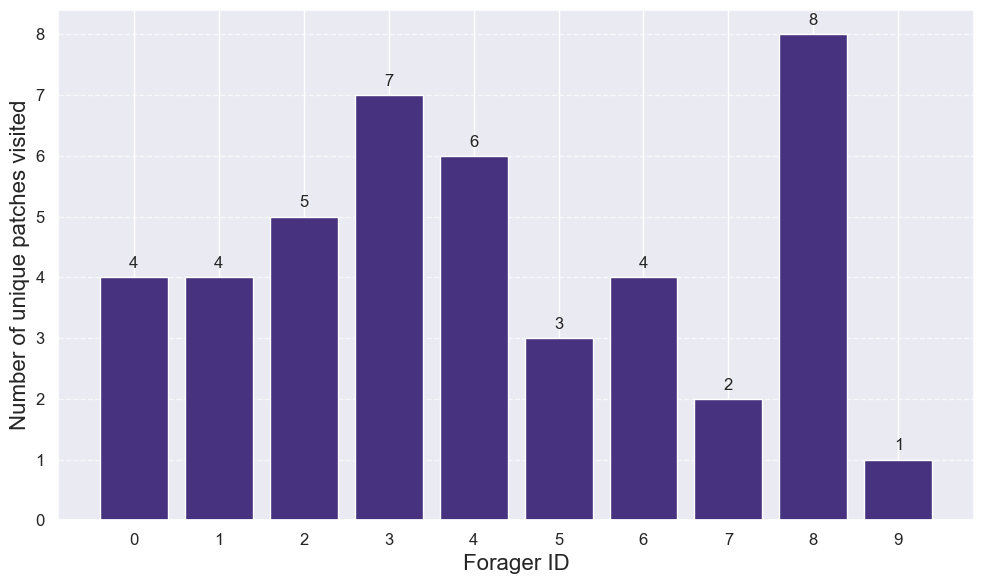

{'forager_ids': array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 'patch_counts': array([4, 4, 5, 7, 6, 3, 4, 2, 8, 1]),
 'visits_matrix': array([[False, False, False, False, False,  True,  True,  True, False,
          True],
        [False, False, False,  True, False, False,  True,  True, False,
          True],
        [False, False, False,  True, False,  True,  True,  True, False,
          True],
        [ True,  True, False, False, False,  True,  True,  True,  True,
          True],
        [ True,  True, False, False, False,  True,  True, False,  True,
          True],
        [False, False, False, False, False,  True,  True, False, False,
          True],
        [False, False, False, False, False,  True,  True,  True, False,
          True],
        [ True, False, False, False, False, False, False, False,  True,
         False],
        [ True,  True,  True, False,  True,  True,  True,  True, False,
          True],
        [False, False, False,  True, False, False, False, False, False,

In [7]:
RENDER_DATA_PATH = "./trajectories_s_7/"
forager_xs = jnp.load(RENDER_DATA_PATH + 'rendering_foragers_xs.npy')
forager_ys = jnp.load(RENDER_DATA_PATH + 'rendering_foragers_ys.npy')
forager_angs = jnp.load(RENDER_DATA_PATH + 'rendering_foragers_angs.npy')
forager_energies = jnp.load(RENDER_DATA_PATH + 'rendering_foragers_energies.npy')
patch_xs = jnp.load(RENDER_DATA_PATH + 'rendering_patch_xs.npy')
patch_ys = jnp.load(RENDER_DATA_PATH + 'rendering_patch_ys.npy')
patch_energies = jnp.load(RENDER_DATA_PATH + 'rendering_patch_energies.npy')

print(forager_xs.shape, forager_ys.shape, forager_angs.shape, patch_xs.shape, patch_ys.shape, patch_energies.shape)


forager_xs = jnp.reshape(forager_xs, (forager_xs.shape[0], EP_LEN, NUM_FORAGERS))
forager_ys = jnp.reshape(forager_ys, (forager_ys.shape[0], EP_LEN, NUM_FORAGERS))
forager_angs = jnp.reshape(forager_angs, (forager_angs.shape[0], EP_LEN, NUM_FORAGERS))
forager_energies = jnp.reshape(forager_energies, (forager_energies.shape[0], EP_LEN, NUM_FORAGERS))
patch_xs = jnp.reshape(patch_xs, (patch_xs.shape[0], NUM_PATCH))
patch_ys = jnp.reshape(patch_ys, (patch_ys.shape[0], NUM_PATCH))
patch_energies = jnp.reshape(patch_energies, (patch_energies.shape[0], EP_LEN, NUM_PATCH))


print(forager_xs.shape, forager_ys.shape, forager_angs.shape, patch_xs.shape, patch_ys.shape, patch_energies.shape)
rendering_idxs = [0, 43]

rendering_idx = 0

forager_xs_un_opt = forager_xs[rendering_idxs[rendering_idx]]
forager_ys_un_opt = forager_ys[rendering_idxs[rendering_idx]]
forager_angs_un_opt = forager_angs[rendering_idxs[rendering_idx]]
#forager_energies = forager_energies[rendering_idxs[rendering_idx]]
patch_xs_un_opt = patch_xs[rendering_idxs[rendering_idx]]
patch_ys_un_opt = patch_ys[rendering_idxs[rendering_idx]]
patch_energies_un_opt = patch_energies[rendering_idxs[rendering_idx]]


render_data = Params(
    content={
        'forager_xs': forager_xs_un_opt,
        'forager_ys': forager_ys_un_opt,
        'forager_angs': forager_angs_un_opt,
        'patch_xs': patch_xs_un_opt,
        'patch_ys': patch_ys_un_opt,
        'patch_energies': patch_energies_un_opt
    }
)
render_static_trajectory(render_data, "./figs/before_optimization_s_7.png")

rendering_idx = 1

forager_xs_opt = forager_xs[rendering_idxs[rendering_idx]]
forager_ys_opt = forager_ys[rendering_idxs[rendering_idx]]
forager_angs_opt = forager_angs[rendering_idxs[rendering_idx]]
#forager_energies = forager_energies[rendering_idxs[rendering_idx]]
patch_xs_opt = patch_xs[rendering_idxs[rendering_idx]]
patch_ys_opt = patch_ys[rendering_idxs[rendering_idx]]
patch_energies_opt = patch_energies[rendering_idxs[rendering_idx]]

print(forager_xs.shape, forager_ys.shape, forager_angs.shape, patch_xs.shape, patch_ys.shape, patch_energies.shape)

render_data = Params(
    content={
        'forager_xs': forager_xs_opt,
        'forager_ys': forager_ys_opt,
        'forager_angs': forager_angs_opt,
        'patch_xs': patch_xs_opt,
        'patch_ys': patch_ys_opt,
        'patch_energies': patch_energies_opt
    }
)
render_static_trajectory(render_data, "./figs/after_optimization_s_7.png")
plot_patch_visits(render_data, "./figs/patch_visits_s_7.png")

(39, 2000, 10, 1) (39, 2000, 10, 1) (39, 2000, 10, 1) (39, 10) (39, 10) (39, 2000, 10, 1)
(39, 2000, 10) (39, 2000, 10) (39, 2000, 10) (39, 10) (39, 10) (39, 2000, 10)


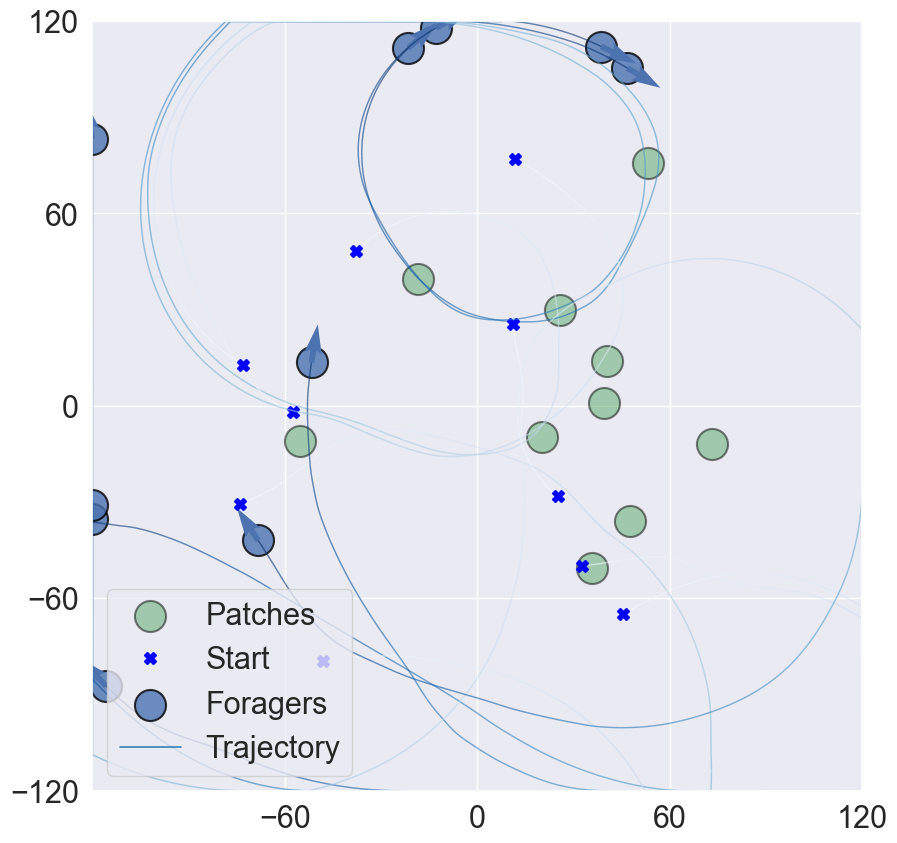

(39, 2000, 10) (39, 2000, 10) (39, 2000, 10) (39, 10) (39, 10) (39, 2000, 10)


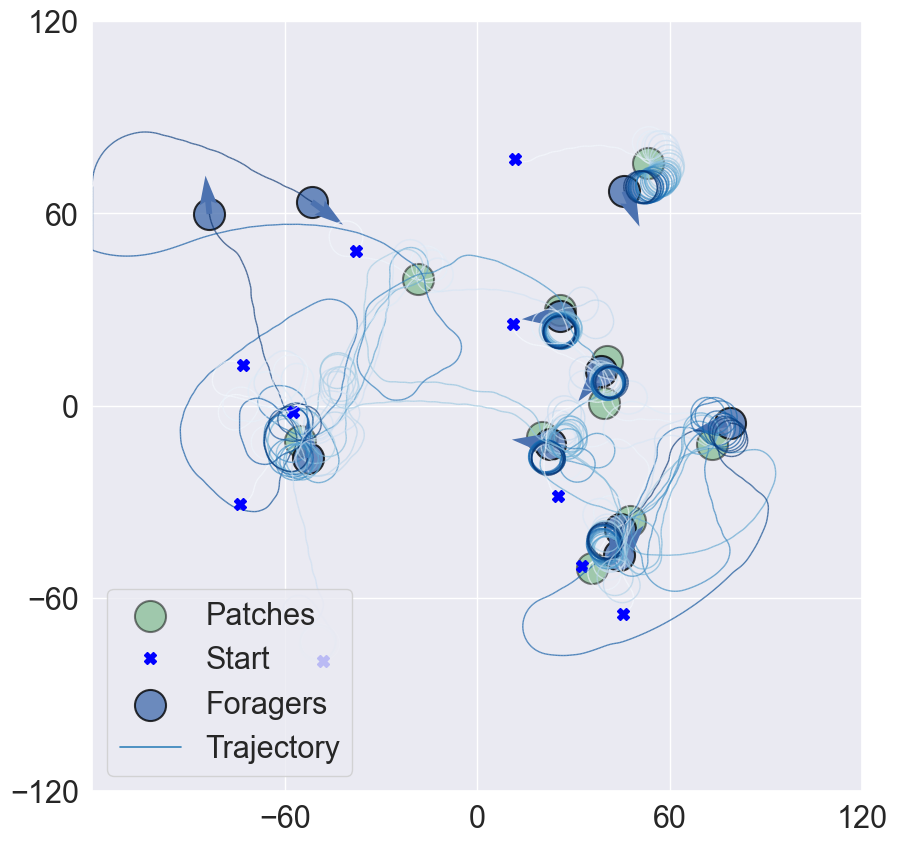

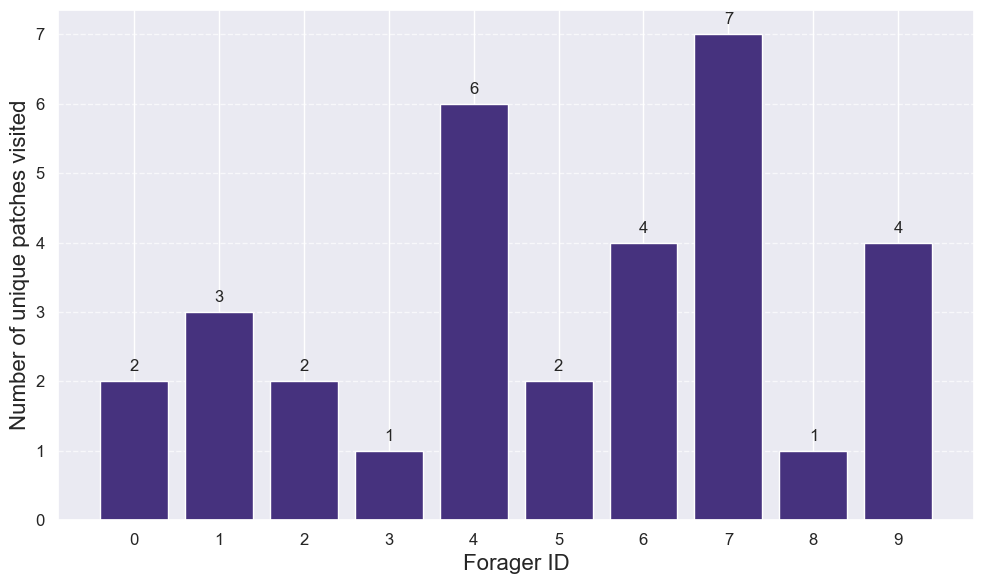

{'forager_ids': array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 'patch_counts': array([2, 3, 2, 1, 6, 2, 4, 7, 1, 4]),
 'visits_matrix': array([[False, False, False, False, False,  True, False, False,  True,
         False],
        [ True, False, False, False, False, False,  True,  True, False,
         False],
        [False,  True, False, False, False, False, False, False,  True,
         False],
        [False,  True, False, False, False, False, False, False, False,
         False],
        [ True,  True,  True, False, False, False,  True,  True,  True,
         False],
        [False, False, False, False, False, False,  True,  True, False,
         False],
        [False, False,  True, False,  True, False,  True,  True, False,
         False],
        [ True,  True, False,  True,  True,  True,  True, False,  True,
         False],
        [False, False, False, False, False, False, False, False, False,
          True],
        [ True, False, False,  True,  True,  True, False, False, False,

In [8]:
RENDER_DATA_PATH = "./trajectories_s_5/"
forager_xs = jnp.load(RENDER_DATA_PATH + 'rendering_foragers_xs.npy')
forager_ys = jnp.load(RENDER_DATA_PATH + 'rendering_foragers_ys.npy')
forager_angs = jnp.load(RENDER_DATA_PATH + 'rendering_foragers_angs.npy')
forager_energies = jnp.load(RENDER_DATA_PATH + 'rendering_foragers_energies.npy')
patch_xs = jnp.load(RENDER_DATA_PATH + 'rendering_patch_xs.npy')
patch_ys = jnp.load(RENDER_DATA_PATH + 'rendering_patch_ys.npy')
patch_energies = jnp.load(RENDER_DATA_PATH + 'rendering_patch_energies.npy')

print(forager_xs.shape, forager_ys.shape, forager_angs.shape, patch_xs.shape, patch_ys.shape, patch_energies.shape)


forager_xs = jnp.reshape(forager_xs, (forager_xs.shape[0], EP_LEN, NUM_FORAGERS))
forager_ys = jnp.reshape(forager_ys, (forager_ys.shape[0], EP_LEN, NUM_FORAGERS))
forager_angs = jnp.reshape(forager_angs, (forager_angs.shape[0], EP_LEN, NUM_FORAGERS))
forager_energies = jnp.reshape(forager_energies, (forager_energies.shape[0], EP_LEN, NUM_FORAGERS))
patch_xs = jnp.reshape(patch_xs, (patch_xs.shape[0], NUM_PATCH))
patch_ys = jnp.reshape(patch_ys, (patch_ys.shape[0], NUM_PATCH))
patch_energies = jnp.reshape(patch_energies, (patch_energies.shape[0], EP_LEN, NUM_PATCH))


print(forager_xs.shape, forager_ys.shape, forager_angs.shape, patch_xs.shape, patch_ys.shape, patch_energies.shape)
rendering_idxs = [0, 39]

rendering_idx = 0

forager_xs_un_opt = forager_xs[rendering_idxs[rendering_idx]]
forager_ys_un_opt = forager_ys[rendering_idxs[rendering_idx]]
forager_angs_un_opt = forager_angs[rendering_idxs[rendering_idx]]
#forager_energies = forager_energies[rendering_idxs[rendering_idx]]
patch_xs_un_opt = patch_xs[rendering_idxs[rendering_idx]]
patch_ys_un_opt = patch_ys[rendering_idxs[rendering_idx]]
patch_energies_un_opt = patch_energies[rendering_idxs[rendering_idx]]


render_data = Params(
    content={
        'forager_xs': forager_xs_un_opt,
        'forager_ys': forager_ys_un_opt,
        'forager_angs': forager_angs_un_opt,
        'patch_xs': patch_xs_un_opt,
        'patch_ys': patch_ys_un_opt,
        'patch_energies': patch_energies_un_opt
    }
)
render_static_trajectory(render_data, "./figs/before_optimization_s_5.png")

rendering_idx = 1

forager_xs_opt = forager_xs[rendering_idxs[rendering_idx]]
forager_ys_opt = forager_ys[rendering_idxs[rendering_idx]]
forager_angs_opt = forager_angs[rendering_idxs[rendering_idx]]
#forager_energies = forager_energies[rendering_idxs[rendering_idx]]
patch_xs_opt = patch_xs[rendering_idxs[rendering_idx]]
patch_ys_opt = patch_ys[rendering_idxs[rendering_idx]]
patch_energies_opt = patch_energies[rendering_idxs[rendering_idx]]

print(forager_xs.shape, forager_ys.shape, forager_angs.shape, patch_xs.shape, patch_ys.shape, patch_energies.shape)

render_data = Params(
    content={
        'forager_xs': forager_xs_opt,
        'forager_ys': forager_ys_opt,
        'forager_angs': forager_angs_opt,
        'patch_xs': patch_xs_opt,
        'patch_ys': patch_ys_opt,
        'patch_energies': patch_energies_opt
    }
)
render_static_trajectory(render_data, "./figs/after_optimization_s_5.png")
plot_patch_visits(render_data, "./figs/patch_visits_s_5.png")